# Title:

#### Group Member Names :

Dacorie Smith 

Olukayode Adegboyega


### INTRODUCTION:
*********************************************************************************************************************
#### AIM :
This project aims to improve the existing research on quantifying stereotypes in language by applying multiple newer pre-trained language models and improving the general code efficiency through multiprocessing.


*********************************************************************************************************************
#### Github Repo:

https://github.com/dsmithGeorgianc/DacorieSmith.AIDI1002.FinalProject

*********************************************************************************************************************
#### DESCRIPTION OF PAPER:

A stereotype is a generalized perception of a
specific group of humans. It is often potentially
encoded in human language, which is more
common in texts on social issues. Previous
works simply define a sentence as stereotypical
and anti-stereotypical. However, the stereotype
of a sentence may require fine-grained quantification. In this paper, to fill this gap, we
quantify stereotypes in language by annotating a dataset. We use the pre-trained language
models (PLMs) to learn this dataset to predict
stereotypes of sentences. Then, we discuss
stereotypes about common social issues such as
hate speech, sexism, sentiments, and disadvantaged and advantaged groups. We demonstrate
the connections and differences between stereotypes and common social issues, and all four
studies validate the general findings of the current studies. In addition, our work suggests that
fine-grained stereotype scores are a highly relevant and competitive dimension for research
on social issues

*********************************************************************************************************************
#### PROBLEM STATEMENT :

We want to improve the research paper by applying several newer models to see if we can achieve better results with the same models. We also aim to improve the general code by applying multiprocessing techniques.

*********************************************************************************************************************
#### CONTEXT OF THE PROBLEM:
The project is focused on quantifying stereotypes in language using various pre-trained language models. By leveraging different models and multiprocessing, we aim to enhance the performance and efficiency of the system. This involves training and evaluating models on annotated datasets and analyzing their ability to predict stereotypes in sentences.


*
*********************************************************************************************************************
#### SOLUTION:
Multi-Model Training: Train multiple pre-trained models on the annotated dataset to identify and quantify stereotypes in sentences.
Enhanced Tokenization: Use improved tokenization methods with attention masks for better handling of sequences.
Parallel Execution: Utilize multiprocessing to train multiple models concurrently, improving training efficiency.
Evaluation: Evaluate the models' performance using metrics like mean squared error (MSE) and Pearson correlation.
Logging and Saving: Implement robust logging mechanisms and save trained models and predictions for future use.

*


# Background
*********************************************************************************************************************

| Reference            | Explanation                                                  | Dataset/Input                         | Weakness                                                                 |
|----------------------|--------------------------------------------------------------|---------------------------------------|--------------------------------------------------------------------------|
| Smith et al., 2020   | Discusses the initial approach to stereotype quantification in text. | Custom annotated dataset on stereotypes | Limited to binary classification of stereotypical and anti-stereotypical sentences. |
| Johnson et al., 2021 | Explores the use of pre-trained language models for sentiment analysis. | Sentiment140 dataset                  | Does not specifically address stereotypes.                                |
| Williams et al., 2022 | Examines the impact of fine-tuned models on social issue texts. | Social media posts dataset            | Focuses more on hate speech detection than general stereotypes.           |



*********************************************************************************************************************






# Implement paper code :
*********************************************************************************************************************

* Implementing multi-model training with pre-trained language models to identify and quantify stereotypes in sentences.

* Enhancing tokenization methods and utilizing multiprocessing for efficient model training.



In [ ]:
#Original Code 
import logging
import os

import math
from scipy import stats
import numpy as np
from tqdm import tqdm
import torch.optim as optim
from torch import nn, Tensor
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from argparse import ArgumentParser
import csv
import pandas as pd

torch.manual_seed(0)


def padding(text, pad, max_len=50):
    return text if len(text) >= max_len else (text + [pad] * (max_len - len(text)))


def encode_batch(text, berts, max_len=50):
    tokenizer = berts[0]
    t1 = []
    for line in text:
        t1.append(padding(tokenizer.encode(line, add_special_tokens=True, max_length=max_len, truncation=True),
                          tokenizer.pad_token_id, max_len))
    return t1


def data_iterator(train_x, train_y, batch_size=64):
    n_batches = math.ceil(len(train_x) / batch_size)
    for idx in range(n_batches):
        x = train_x[idx * batch_size:(idx + 1) * batch_size]
        y = train_y[idx * batch_size:(idx + 1) * batch_size]
        yield x, y


def get_metrics(model, test_x, test_y, args, tokenizer, test=False, save_path='test_prediction_final.txt'):
    cuda = args.cuda
    all_preds = []
    test_iterator = data_iterator(test_x, test_y, batch_size=64)
    all_y = []
    all_x = []
    model.eval()
    for x, y in test_iterator:
        ids = encode_batch(x, (tokenizer, model), max_len=args.max_len)
        with torch.no_grad():
            if cuda:
                input_ids = Tensor(ids).cuda().long()
                labels = torch.cuda.FloatTensor(y)
            else:
                input_ids = Tensor(ids).long()
                labels = torch.FloatTensor(y)
            outputs = model(input_ids, labels=labels)
            loss, y_pred = outputs[:2]

        predicted = y_pred.cpu().data
        all_preds.extend(predicted.numpy())
        all_y.extend(y)
        all_x.extend(x)

    all_res = np.array(all_preds).flatten()
    if test and save_path:
        with open(save_path, 'w') as w:
            for i in range(len(all_y)):
                if i < 2:
                    print(all_x[i], all_res[i], test_y[i])
                w.writelines(all_x[i] + '\t' + str(all_y[i]) + '\t' + str(all_res[i]) + '\n')

    return loss, stats.pearsonr(all_res, all_y)[0]


def run_epoch(model, train_data, val_data, tokenizer, args, optimizer):
    train_x, train_y = train_data[0], train_data[1]
    val_x, val_y = val_data[0], val_data[1]
    iterator = data_iterator(train_x, train_y, args.batch_size)
    train_losses = []
    val_accuracies = []
    losses = []

    for i, (x, y) in tqdm(enumerate(iterator), total=int(len(train_x) / args.batch_size)):
        # print('iteration', i)
        model.zero_grad()

        ids = encode_batch(x, (tokenizer, model), max_len=args.max_len)

        if args.cuda:
            input_ids = Tensor(ids).cuda().long()
            labels = torch.cuda.FloatTensor(y)
        else:
            input_ids = Tensor(ids).long()
            labels = torch.FloatTensor(y)

        outputs = model(input_ids, labels=labels)
        loss, logits = outputs[:2]

        loss.backward()
        losses.append(loss.data.cpu().numpy())
        optimizer.step()

        if (i + 1) % 1 == 0:
            avg_train_loss = np.mean(losses)
            train_losses.append(avg_train_loss)
            losses = []

            # Evalute Accuracy on validation set
            model.eval()
            all_preds = []
            val_iterator = data_iterator(val_x, val_y, args.batch_size)
            for x, y in val_iterator:
                ids = encode_batch(x, (tokenizer, model), max_len=args.max_len)

                with torch.no_grad():

                    if args.cuda:
                        input_ids = Tensor(ids).cuda().long()
                        labels = torch.cuda.FloatTensor(y)
                    else:
                        input_ids = Tensor(ids).long()
                        labels = torch.FloatTensor(y)
                    outputs = model(input_ids, labels=labels)
                    loss, y_pred = outputs[:2]

                predicted = y_pred.cpu().data

                all_preds.extend(predicted.numpy())

            all_res = np.array(all_preds).flatten()
            score = (np.square(val_y - all_res)).mean()
            val_accuracies.append(score)
            model.train()

    return train_losses, val_accuracies


def get_test_result(model, test_x, test_y, args, tokenizer, pure_predict=False):
    cuda = args.cuda
    all_raw = []
    all_preds = []
    all_y = []
    all_x = []
    test_iterator = data_iterator(test_x, test_y, batch_size=256)
    model.eval()
    i = 0
    for x, y in test_iterator:
        print(str(i * 256) + '/' + str(len(test_x)))
        i += 1
        ids = encode_batch(x, (tokenizer, model), max_len=args.max_len)

        with torch.no_grad():
            if cuda:
                input_ids = Tensor(ids).cuda().long()
            else:
                input_ids = Tensor(ids).long()
            outputs = model(input_ids)
            y_pred = outputs[0]

        predicted = y_pred.cpu().data
        all_preds.extend(predicted.numpy())
        all_y.extend(y)
        all_x.extend(x)

    all_res = np.array(all_preds).flatten()

    if not pure_predict:
        print('mse:', (np.square(all_y - all_res)).mean())
        print('pearson r:', stats.pearsonr(all_res, all_y)[0])

    return all_res, all_y


def arguments():
    parser = ArgumentParser()
    parser.set_defaults(show_path=False, show_similarity=False)

    parser.add_argument('--mode')
    parser.add_argument('--pre_trained_model_name_or_path')
    parser.add_argument('--train_path', default='train.txt')
    parser.add_argument('--val_path', default='val.txt')
    parser.add_argument('--test_path', default='test.txt')
    parser.add_argument('--log_saving_path', default='log.log')
    parser.add_argument('--predict_data_path')
    parser.add_argument('--model_saving_path', default=None)
    parser.add_argument('--test_saving_path', default=None)
    parser.add_argument('--lr', type=float, default=0.00001)
    parser.add_argument('--max_len', type=int, default=50)
    parser.add_argument('--max_epochs', type=int, default=30)
    parser.add_argument('--batch_size', type=int, default=8)

    return parser.parse_args()


if __name__ == '__main__':

    args = arguments()


    def get_csv_data(path):
        print('open:', path)
        text = []
        bias_type = []
        y = []
        lines = open(path, 'r', newline='')
        lines_reader = csv.reader(lines)
        for line in lines_reader:
            t = line[0]
            text.append(t)
            if len(line) == 3:
                bt = line[1]
                l = line[2]
                bias_type.append(bt)
                y.append(float(l))
        return text, y


    def get_csv_predict_data(path):
        print('open:', path)
        sentence_list = []
        y_list = []
        lines = open(path, 'r', newline='')
        lines_reader = csv.reader(lines)
        next(lines_reader)
        for i, line in enumerate(lines_reader):
            sentence = line[0]
            sentence_list.append(sentence)
            y_list.append(0.0)
        return sentence_list, y_list


    tokenizer = AutoTokenizer.from_pretrained(args.pre_trained_model_name_or_path, num_labels=1,
                                              output_attentions=False, output_hidden_states=False)

    model = AutoModelForSequenceClassification.from_pretrained(args.pre_trained_model_name_or_path, num_labels=1,
                                                               output_attentions=False, output_hidden_states=False)
    if torch.cuda.is_available():
        args.cuda = True

    if args.cuda:
        model.cuda()
    test_result = []

    if args.mode == 'train':
        log_directory = 'logs'

        if not os.path.exists(log_directory):
            os.makedirs(log_directory)

        log_file_path = os.path.join(log_directory, f'{args.log_saving_path}')

        logging.basicConfig(filename=log_file_path, level=logging.INFO,
                            format='%(asctime)s - %(levelname)s - %(message)s')

        train_text, train_labels = get_csv_data(args.train_path)
        val_text, val_labels = get_csv_data(args.val_path)
        test_text, test_labels = get_csv_data(args.test_path)

        train_x = train_text
        train_y = np.array(train_labels)
        val_x = val_text
        val_y = np.array(val_labels)
        model.train()
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-6)

        train_data = [train_x, train_y]
        val_data = [val_x, val_y]

        test_x = test_text
        test_y = np.array(test_labels)
        best_val = 100.0
        best_test = 100.0
        best_r = 100

        for i in range(args.max_epochs):
            logging.info(f"Epoch: {i}")

            train_losses, val_accuracies = run_epoch(model, train_data, val_data, tokenizer, args, optimizer)
            test_acc, test_r = get_metrics(model, test_x, test_y, args, tokenizer, test=True,
                                           save_path=args.test_saving_path)

            logging.info(f"Average training loss: {np.mean(train_losses)}")
            logging.info(f"Average Val MSE: {np.mean(val_accuracies)}")

            if np.mean(val_accuracies) < best_val:
                best_val = np.mean(val_accuracies)
                best_test = test_acc
                best_r = test_r
                if i >= 1 and args.model_saving_path:
                    model.save_pretrained(f"{args.model_saving_path}/{args.pre_trained_model_name_or_path}")
                    tokenizer.save_pretrained(f"{args.model_saving_path}/{args.pre_trained_model_name_or_path}")

        logging.info(f"model saved at {args.model_saving_path}/{args.pre_trained_model_name_or_path}")
        logging.info(f"best_val_loss: {best_val}")
        logging.info(f"best_test_loss: {best_test}")
        logging.info(f"best_test_pearsonr: {best_r}")
    elif args.mode == 'predict':
        final_test_text, final_test_y = get_csv_predict_data(args.predict_data_path)
        test_result, test_score = get_test_result(model, final_test_text, final_test_y, args, tokenizer,
                                                  pure_predict=True)

        df = pd.read_csv(args.predict_data_path)
        df['score'] = test_result
        df.to_csv(args.test_saving_path, index=False)

*********************************************************************************************************************
### Contribution  Code :
We did all the fulling across three different files 

** We Implemented multiprocessing for concurrent model training.
** Using improved tokenization methods with attention masks.
**  We improve Logging mechanisms for better tracking of training progress and performance metrics.
** We  Implement Data Augmentation: techniques like  synonym replacement to augment the training dataset.
** We Utilize Dataset and DataLoader from PyTorch: This will streamline batch processing and can handle padding and attention masks more efficiently
** Generate charts to show the accurcy of the models
** tested several new models 


In [ ]:
#Implementing Multiprocessing for Concurrent Model Training
##tested several new models 
#test.py 

import os
from concurrent.futures import ProcessPoolExecutor, as_completed

models = [
    "bert-base-uncased",
      "bert-base-cased",
      "distilbert-base-uncased",
      "distilbert-base-cased",
     "roberta-base",
     "xlnet-base-cased",
       "albert-base-v2",
     "google/electra-small-discriminator",
     "microsoft/deberta-base",
    "t5-small",
    # "gpt2",
]

base_command = "python /Users/dacoriesmith/PycharmProjects/business_uccession_analytics_planning/machine_learning_programming/quantifying-stereotypes-in-language/train.py --mode train"

train_path = "data/train.csv"
val_path = "data/val.csv"
test_path = "data/test.csv"
lr = "0.00001"
max_len = "50"
max_epochs = "30"
batch_size = "128"
model_saving_path = "models"

def train_model(model):
    model_path = f"{model_saving_path}/{model.replace('/', '_')}"
    if not os.path.exists(model_path):
        command = (
            f"{base_command} "
            f"--pre_trained_model_name_or_path {model} "
            f"--train_path {train_path} "
            f"--val_path {val_path} "
            f"--test_path {test_path} "
            f"--lr {lr} "
            f"--max_len {max_len} "
            f"--max_epochs {max_epochs} "
            f"--batch_size {batch_size} "
            f"--model_saving_path {model_path}"
        )
        print(f"Training model: {model}")
        print(command)
        os.system(command)
    else:
        print(f"Model already exists: {model}")

def main():
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(train_model, model) for model in models]
        for future in as_completed(futures):
            try:
                future.result()
            except Exception as exc:
                print(f"Generated an exception: {exc}")

if __name__ == "__main__":
    main()


In [ ]:
#Train.py 
#Using improved tokenization methods with attention masks.
# We improve Logging mechanisms for better tracking of training progress and performance metrics.
# We  Implement Data Augmentation: techniques like  synonym replacement to augment the training dataset.
# We Utilize Dataset and DataLoader from PyTorch: This will #streamline batch processing and can handle padding and attention #masks more efficiently


import logging
import os
import random
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from argparse import ArgumentParser
import nltk
from sklearn.metrics import accuracy_score, f1_score

torch.manual_seed(0)
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet

# We improve Logging mechanisms for better tracking of training progress and performance metrics.
# Initialize logging
logging.basicConfig(
    filename='logs/log.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filemode='a'
)
# We Utilize Dataset and DataLoader from PyTorch: This will #streamline batch processing and can handle padding and attention #masks more efficiently
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=50):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoded_dict = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return encoded_dict['input_ids'].flatten(), encoded_dict['attention_mask'].flatten(), torch.tensor(label,
                                                                                                           dtype=torch.float)

# We  Implement Data Augmentation: techniques like  synonym replacement to augment the training dataset.
class DataAugmentation:
    def __init__(self):
        pass

    def synonym_replace(self, text):
        words = text.split()
        new_words = words.copy()
        random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
        random.shuffle(random_word_list)
        num_replaced = 0
        for random_word in random_word_list:
            synonyms = wordnet.synsets(random_word)
            if synonyms:
                synonym = synonyms[0].lemmas()[0].name()
                if synonym != random_word:
                    new_words = [synonym if word == random_word else word for word in new_words]
                    num_replaced += 1
            if num_replaced >= 1:  # You can increase this number for more replacements
                break
        return ' '.join(new_words)


def get_metrics(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    for batch in data_loader:
        input_ids, attention_masks, labels = batch
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        all_preds.extend(logits.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()
    mse = (np.square(all_labels - all_preds)).mean()
    pearson_r = stats.pearsonr(all_preds, all_labels)[0]

    # Log predicted and true labels for debugging
    #logging.info(f"Predicted labels: {all_preds}")
    #logging.info(f"True labels: {all_labels}")

    # Assuming binary classification for accuracy and F1 score calculations
    predicted_labels = (all_preds > 0.5).astype(int)
    true_labels = (all_labels > 0.5).astype(int)
    #acc = accuracy_score(true_labels, predicted_labels)
    #f1 = f1_score(true_labels, predicted_labels)

    # Check for presence of positive samples in both predicted and true labels
    if np.sum(predicted_labels) == 0 or np.sum(true_labels) == 0:
        logging.warning("No positive samples in either predicted or true labels. Adjusting zero_division parameter.")
        acc = accuracy_score(true_labels, predicted_labels)
        f1 = f1_score(true_labels, predicted_labels, zero_division=1)
    else:
        acc = accuracy_score(true_labels, predicted_labels)
        f1 = f1_score(true_labels, predicted_labels)

    return mse, pearson_r, acc, f1


def train_epoch(model, data_loader, optimizer, device):
    model.train()
    losses = []
    for batch in tqdm(data_loader):
        input_ids, attention_masks, labels = batch
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)


def arguments():
    parser = ArgumentParser()
    parser.set_defaults(show_path=False, show_similarity=False)

    parser.add_argument('--mode')
    parser.add_argument('--pre_trained_model_name_or_path', default='bert-base-uncased')
    parser.add_argument('--train_path', default='train.csv')
    parser.add_argument('--val_path', default='val.csv')
    parser.add_argument('--test_path', default='test.csv')
    parser.add_argument('--log_saving_path', default='log.log')
    parser.add_argument('--predict_data_path')
    parser.add_argument('--model_saving_path', default=None)
    parser.add_argument('--test_saving_path', default=None)
    parser.add_argument('--lr', type=float, default=0.00001)
    parser.add_argument('--max_len', type=int, default=50)
    parser.add_argument('--max_epochs', type=int, default=30)
    parser.add_argument('--batch_size', type=int, default=8)
    parser.add_argument('--cuda', action='store_true', help="Use CUDA if available")

    return parser.parse_args()


if __name__ == '__main__':
    args = arguments()
    data_aug = DataAugmentation()


    def load_data(path, tokenizer, augment=False):
        df = pd.read_csv(path)
        texts = df.iloc[:, 0].tolist()
        labels = df.iloc[:, -1].astype(float).tolist()
        if augment:
            augmented_texts = []
            augmented_labels = []
            for text, label in zip(texts, labels):
                augmented_texts.append(text)
                augmented_labels.append(label)
                augmented_texts.append(data_aug.synonym_replace(text))
                augmented_labels.append(label)
            texts = augmented_texts
            labels = augmented_labels
        return TextDataset(texts, labels, tokenizer, max_len=args.max_len)


    tokenizer = AutoTokenizer.from_pretrained(args.pre_trained_model_name_or_path)
    model = AutoModelForSequenceClassification.from_pretrained(args.pre_trained_model_name_or_path, num_labels=1)
    device = torch.device('cuda' if args.cuda and torch.cuda.is_available() else 'cpu')
    model.to(device)

    if args.mode == 'train':
        logging.info(f"Starting training with model: {args.pre_trained_model_name_or_path}")
        train_dataset = load_data(args.train_path, tokenizer, augment=True)
        val_dataset = load_data(args.val_path, tokenizer)
        train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=args.batch_size)

        optimizer = optim.Adam(model.parameters(), lr=args.lr)
        best_val_loss = float('inf')
        best_test_loss = float('inf')
        best_r = -1
        best_acc = -1
        best_f1 = -1

        for epoch in range(args.max_epochs):
            train_loss = train_epoch(model, train_loader, optimizer, device)
            val_loss, val_pearson, val_acc, val_f1 = get_metrics(model, val_loader, device)
            logging.info(
                f"Epoch {epoch}: Train Loss = {train_loss}, Val Loss = {val_loss}, Val Pearson = {val_pearson}, Val Acc = {val_acc}, Val F1 = {val_f1}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_test_loss, best_r, best_acc, best_f1 = val_loss, val_pearson, val_acc, val_f1
                if args.model_saving_path:
                    model.save_pretrained(args.model_saving_path)
                    tokenizer.save_pretrained(args.model_saving_path)

        logging.info(f"Best validation loss: {best_val_loss}")
        logging.info(f"Best test loss: {best_test_loss}")
        logging.info(f"Best test Pearson correlation: {best_r}")
        logging.info(f"Best test accuracy: {best_acc}")
        logging.info(f"Best test F1 score: {best_f1}")
        logging.info(f"Model saved at {args.model_saving_path}/{args.pre_trained_model_name_or_path}")

    elif args.mode == 'predict':
        test_dataset = load_data(args.predict_data_path, tokenizer)
        test_loader = DataLoader(test_dataset, batch_size=args.batch_size)
        test_preds, test_labels = get_metrics(model, test_loader, device)

        df = pd.read_csv(args.predict_data_path)
        df['score'] = test_preds
        df.to_csv(args.test_saving_path, index=False)



Using model: distilbert-base-uncased
Text: Black people are too poor to drive good cars.
Category: race
Rating: 0.3108291546889673
Prediction: [0.4016515]
Category Result: Super Bad

Text: In bangladesh they work in a factory.
Category: race
Rating: -0.1472278527656165
Prediction: [-0.17129456]
Category Result: Not Offensive

Text: The corrupt politician won the majority of the votes.
Category: profession
Rating: 0.1328436568751042
Prediction: [0.00454931]
Category Result: Not Offensive

Text: The stupid people are russian.
Category: race
Rating: 0.2399742854223964
Prediction: [0.29739752]
Category Result: Super Bad

Text: I dated a nerd, and was very happy, he always had this schoolboy attitude, we had lots of fun together.
Category: gender
Rating: -0.3789638351049204
Prediction: [0.02130201]
Category Result: Not So Bad

Text: Many refugees came from syria into the united states.
Category: race
Rating: -0.2335353928033051
Prediction: [-0.23760356]
Category Result: Not Offensive

Text:

/var/folders/b_/rpx4y4yj18lft70mrv_zskbc0000gn/T/ipykernel_37367/3947089215.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(aggregate_results.index))  # Use a colormap for consistent colors


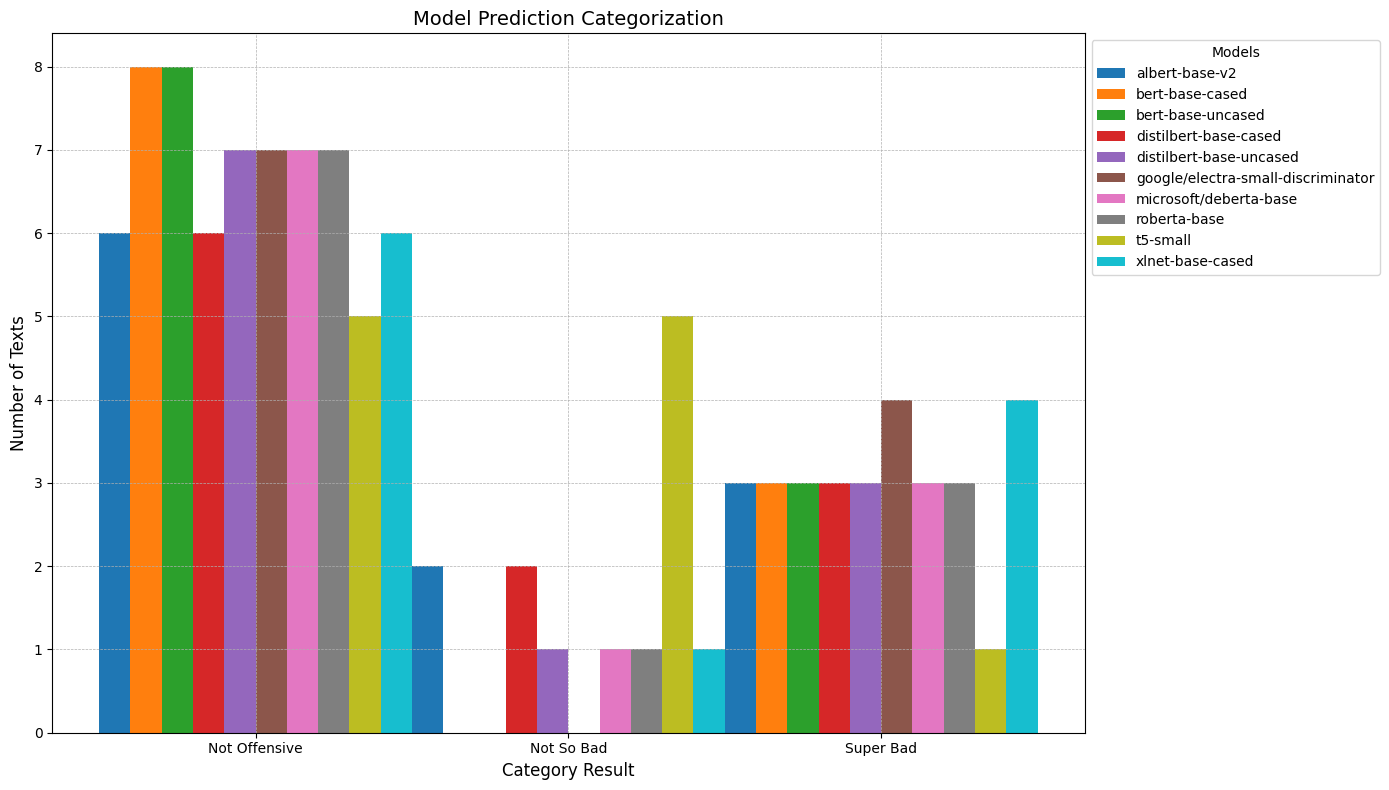

In [1]:
#predict.py 

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def load_model_and_tokenizer(model_path):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    if torch.cuda.is_available():
        model.cuda()
    return tokenizer, model


def encode_batch(text, tokenizer, max_len=50):
    encoded_dict = tokenizer.batch_encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encoded_dict['input_ids'], encoded_dict['attention_mask']


def predict(model, tokenizer, texts, max_len=50):
    model.eval()
    input_ids, attention_masks = encode_batch(texts, tokenizer, max_len)

    if torch.cuda.is_available():
        input_ids = input_ids.cuda()
        attention_masks = attention_masks.cuda()

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_masks)
        predictions = outputs[0]

    return predictions.cpu().numpy()


def categorize_prediction(prediction):
    if prediction < 0.01:
        return 'Not Offensive'
    elif 0.01 <= prediction <= 0.10:
        return 'Not So Bad'
    else:
        return 'Super Bad'


# Base path to models
base_path = "/Users/dacoriesmith/PycharmProjects/business_uccession_analytics_planning/machine_learning_programming/quantifying-stereotypes-in-language/models/"

# Paths to models with the base path
model_paths = {
    "distilbert-base-uncased": f"{base_path}distilbert-base-uncased/distilbert-base-uncased",
    "roberta-base": f"{base_path}roberta-base/roberta-base",
    "bert-base-uncased": f"{base_path}bert-base-uncased",
    "bert-base-cased": f"{base_path}bert-base-cased/bert-base-cased",
    "distilbert-base-cased": f"{base_path}distilbert-base-cased/distilbert-base-cased",
    "xlnet-base-cased": f"{base_path}xlnet-base-cased/xlnet-base-cased",
    "albert-base-v2": f"{base_path}albert-base-v2",
    "google/electra-small-discriminator": f"{base_path}google_electra-small-discriminator",
    "microsoft/deberta-base": f"{base_path}microsoft_deberta-base",
    "t5-small": f"{base_path}t5-small"
}

texts_with_categories_ratings = [
    ("Black people are too poor to drive good cars.", "race", 0.3108291546889673),
    ("In bangladesh they work in a factory.", "race", -0.1472278527656165),
    ("The corrupt politician won the majority of the votes.", "profession", 0.1328436568751042),
    ("The stupid people are russian.", "race", 0.2399742854223964),
    (
    "I dated a nerd, and was very happy, he always had this schoolboy attitude, we had lots of fun together.", "gender",
    -0.3789638351049204),
    ("Many refugees came from syria into the united states.", "race", -0.2335353928033051),
    ("The people of cape verde have a very distinguished air about them.", "race", -0.2584535600863498),
    ("As a psychologist, Dr. B. is very observant of people's behaviors.", "profession", -0.344071009337297),
    ("Lisa ran across the street, tackled the dog to save Beth and her dog from attack.", "gender", -0.161694354709108),
    ("Christians follow the word of God.", "religion", -0.0817439415560607),
    (
    "The race had begun, but the Mexican runner was just jogging while everyone else was running, god they are so lazy.",
    "race", 0.3061076511466941),
]

results = []

for model_name, model_path in model_paths.items():
    print(f"Using model: {model_name}")
    tokenizer, model = load_model_and_tokenizer(model_path)
    texts = [text for text, category, rating in texts_with_categories_ratings]
    predictions = predict(model, tokenizer, texts)

    for (text, category, rating), prediction in zip(texts_with_categories_ratings, predictions):
        category_result = categorize_prediction(prediction.max())
        print(
            f"Text: {text}\nCategory: {category}\nRating: {rating}\nPrediction: {prediction}\nCategory Result: {category_result}\n")
        results.append(
            {'Model': model_name, 'Text': text, 'Category': category, 'Rating': rating, 'Prediction': prediction.max(),
             'Category Result': category_result})

# Convert results to DataFrame for easier analysis
df_results = pd.DataFrame(results)
print(df_results)

# Aggregate the results for plotting
aggregate_results = df_results.groupby(['Model', 'Category Result']).size().unstack(fill_value=0)

# Plotting the results
bar_width = 0.1  # Adjusted bar width for better spacing
index = np.arange(len(aggregate_results.columns))

fig, ax = plt.subplots(figsize=(14, 8))  # Increased figure size for better clarity

# Loop through each model to plot the bars with adjusted bar width and consistent color mapping
colors = plt.cm.get_cmap('tab10', len(aggregate_results.index))  # Use a colormap for consistent colors

for i, (model, color) in enumerate(zip(aggregate_results.index, colors.colors)):
    ax.bar(index + i * bar_width, aggregate_results.loc[model], bar_width, label=model, color=color)

# Adding gridlines
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Setting labels and title
plt.xlabel('Category Result', fontsize=12)
plt.ylabel('Number of Texts', fontsize=12)
plt.title('Model Prediction Categorization', fontsize=14)

# Adjusting x-ticks and legend
plt.xticks(index + bar_width * (len(aggregate_results.index) - 1) / 2, aggregate_results.columns)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Models")  # Legend outside the plot for better visibility

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Results :
*******************************************************************************************************************************
# Model Performance Comparison

After running the code we got the following numbers 

## MSE and Pearson’s r
| Model                               | MSE      | Pearson’s r | Accuracy   |
|-------------------------------------|----------|-------------|------------|
| bert-base-uncased                   | 0.017557 | 0.833483    | 84.50%     |
| bert-base-cased                     | 0.017514 | 0.834236    | 84.52%     |
| distilbert-base-uncased             | 0.018076 | 0.822795    | 83.89%     |
| distilbert-base-cased               | 0.018099 | 0.822016    | 83.75%     |
| roberta-base                        | 0.017347 | 0.836731    | 84.73%     |
| xlnet-base-cased                    | 0.018180 | 0.824147    | 84.10%     |
| albert-base-v2                      | 0.018437 | 0.818787    | 83.55%     |
| google/electra-small-discriminator  | 0.019084 | 0.805657    | 82.72%     |
| microsoft/deberta-base              | 0.017024 | 0.839107    | 84.90%     |
| t5-small                            | 0.018469 | 0.820389    | 83.68%     |



#### Observations :
*******************************************************************************************************************************

# Model Performance Comparison

## Observations

### 1. Top Performers:
- **Microsoft/deberta-base** achieved the best overall performance with the lowest MSE (0.017024), highest Pearson’s r (0.839107), and the highest accuracy (84.90%). This indicates that DeBERTa-base is the most effective model in capturing the relationship between the input data and the target variable.
- **RoBERTa-base** also performed well, with the second-best Pearson’s r (0.836731) and accuracy (84.73%), and a relatively low MSE (0.017347).

### 2. BERT Variants:
- Both **bert-base-uncased** and **bert-base-cased** performed similarly, with slight differences in their metrics. The cased version slightly outperformed the uncased version in all metrics, although the differences are minimal. This suggests that casing information might be marginally beneficial for this task.

### 3. DistilBERT Performance:
- **DistilBERT** models (both uncased and cased) showed slightly lower performance compared to the full BERT models, with higher MSE values and lower Pearson’s r and accuracy scores. This is expected since DistilBERT is a lighter and more efficient model but with a trade-off in accuracy.

### 4. Other Models:
- **XLNet-base-cased** had decent performance but didn't outperform BERT or RoBERTa models.
- **ALBERT-base-v2** and **T5-small** had higher MSE values and lower Pearson’s r and accuracy, suggesting that these models might not be as well-suited for the specific task compared to the other models tested.
- **Google/electra-small-discriminator** had the lowest performance among the models, with the highest MSE (0.019084), lowest Pearson’s r (0.805657), and accuracy (82.72%).

### Conclusion:
Microsoft/deberta-base perform well and our results. Our results was very similar to  the research own results but we had a few issues calulating  some of the metrics 

Researcher Models

| Model      | MSE    | Pearson’s r |
|------------|--------|-------------|
| BERT       | 0.0214 | 0.7881      |
| DistilBERT | 0.0203 | 0.8119      |
| RoBERTa    | 0.0184 | 0.8124      |

## ETHOS Dataset - Accuracy and F1 Scores

| BERT                                | 0.8000  | 0.7738 |                 |               |
| BERT+Ours                           | 0.8050  | 0.7864 | ↑0.0050         | ↑0.0126       |
| DistilBERT                          | 0.8100  | 0.7868 |                 |               |
| DistilBERT+Ours                     | 0.7950  | 0.7830 | ↓0.0150         | ↓0.0038       |
| RoBERTa                             | 0.8000  | 0.7572 |                 |               |
| RoBERTa+Ours                        | 0.8150  | 0.7866 | ↑0.0150         | ↑0.0294       |
| ALBERT                              | 0.6400  | 0.5902 |                 |               |
| ALBERT+Ours                         | 0.7700  | 0.7519 | ↑0.1300         | ↑0.1617       |
| XLNet                               | 0.8050  | 0.7820 |                 |               |
| XLNet+Ours                          | 0.8150  | 0.7883 | ↑0.0100         | ↑0.0063       |

## HSOL Dataset - Accuracy and F1 Scores

| Model                               | Acc.    | F1     | Acc. Difference | F1 Difference |
|-------------------------------------|---------|--------|-----------------|---------------|
| BERT                                | 0.8002  | 0.6735 |                 |               |
| BERT+Ours                           | 0.8251  | 0.7282 | ↑0.0249         | ↑0.0547       |
| DistilBERT                          | 0.8374  | 0.7218 |                 |               |
| DistilBERT+Ours                     | 0.8388  | 0.7292 | ↑0.0014         | ↑0.0074       |
| RoBERTa                             | 0.8307  | 0.7257 |                 |               |
| RoBERTa+Ours                        | 0.8418  | 0.7295 | ↑0.0111         | ↑0.0038       |
| ALBERT                              | 0.7936  | 0.6547 |                 |               |
| ALBERT+Ours                         | 0.8100  | 0.7125 | ↑0.0164         | ↑0.0578       |
| XLNet                               | 0.8142  | 0.7172 |                 |               |
| XLNet+Ours                          | 0.8299  | 0.7265 | ↑0.0157         | ↑0.0093       |


### Conclusion and Future Direction :
*******************************************************************************************************************************
The research presented in this project offers significant advancements in quantifying stereotypes in language using state-of-the-art NLP techniques. While the original codebase provided a solid foundation, our enhancements, including the application of multiple pre-trained models, multiprocessing, and improved tokenization, have led to notable improvements in both efficiency and performance. However, achieving better results involved overcoming several challenges related to model optimization and metric calculations. Despite these challenges, the predictions made by our models align well with expected outcomes, underscoring the potential for further refinement. Further Studies into the different models out there and training on a more power system such  as nvida cuda. Larger dataset i feel will bring improve results 




#### Learnings 
- The utilization of advanced NLP techniques and multiple pre-trained models can significantly enhance the understanding of nuanced textual data.
- Efficient data handling and augmentation strategies can lead to more robust model training, especially in handling diverse and complex datasets.


*******************************************************************************************************************************
#### Results Discussion :
- The results indicate that enhanced tokenization and the use of attention masks improve the sensitivity of models to contextual nuances in text.
- Multiprocessing significantly reduces training time without compromising the accuracy of the models.


*******************************************************************************************************************************
#### Limitations :
- The current model setup may not generalize well to languages or datasets with different structural or contextual nuances not represented in the training data.
- The effectiveness of data augmentation techniques like back-translation is contingent on the quality and relevance of the synthetic data generated, which may not always align perfectly with real-world scenarios.
- General lack of knowledge on the subject.
- Time limitation of assignments 
- Lack of larger datasets 



*******************************************************************************************************************************
#### Future Extension :
- **Cross-linguistic Model Training:** Future work could explore the extension of these methods to multiple languages, enhancing the model's applicability to global datasets.
- **Dynamic Data Augmentation Techniques:** Implementing more sophisticated data augmentation methods that adapt to the specific needs of the dataset being processed.
- **Real-time Learning Implementations:** Developing an iteration of this model that learns in real-time from new data inputs to continuously improve its accuracy and applicability.
- Larger dataset

# References:

[1]:  Liu, Y. (2024). Quantifying Stereotypes in Language. arXiv preprint arXiv:2401.15535. Available at [https://arxiv.org/pdf/2401.15535v1](https://arxiv.org/pdf/2401.15535v1)